# Dia 20 de Outubro

Não tem OOP no R, então vou ter que usar funções, começando por construir o teste de Ljung Box

In [3]:
%load_ext rpy2.ipython

## Ex 7

In [ ]:
%%R
numeric(5)

[1] 0 0 0 0 0


In [ ]:
%%R
teste_ljung_box_manual <- function(serie, k) {  # serie e qttd de lags

  n <- length(serie)
  media_serie <- mean(serie)

  autocorrelacoes <- numeric(k)  # vetor de tamanho k com "0's"   - vou usar isso pra botar as autocorrs

  # VARIANCIA <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
  # gamma_0 = sum( (x_t - media)^2 ) / n
  gamma_0 <- sum((serie - media_serie)^2) / n
  #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

  # Loop para cada lag de 1 até k
  for (j in 1:k) {

    # Calcular a autocovariância para o lag j
    # gamma_j = sum( (x_t - media)*(x_{t-j} - media) ) / n
    # Usamos vetores para isso: pegamos a série de (j+1) até o fim
    # e a série do início até (n-j).
    termo1 <- serie[(j+1):n] - media_serie
    termo2 <- serie[1:(n-j)] - media_serie
    gamma_j <- sum(termo1 * termo2) / n

    # Calcular e guardar a autocorrelação (rho_j = gamma_j / gamma_0)
    autocorrelacoes[j] <- gamma_j / gamma_0
  }

  # Passo 2: Calcular a estatística Q de Ljung-Box
  soma_Q <- 0
  for (j in 1:k) {
    termo_soma <- autocorrelacoes[j]^2 / (n - j)
    soma_Q <- soma_Q + termo_soma
  }

  estatistica_Q <- n * (n + 2) * soma_Q

  # Passo 3: Calcular o p-valor
  # A estatística Q segue uma distribuição Qui-Quadrado com 'k' graus de liberdade
  # p-valor é a probabilidade de encontrar um valor >= Q
  p_valor <- pchisq(estatistica_Q, df = k, lower.tail = FALSE)

  # Retornar os resultados em uma lista
  return(list(Q = estatistica_Q, p_valor = p_valor))
}

In [ ]:
%%R
# Gerando a série y_t novamente
set.seed(123)
modelo_arima <- list(order = c(1, 1, 1), ar = 0.8, ma = -0.4)
y_t <- arima.sim(model = modelo_arima, n = 500)

# Testando com lag 1
resultado_y_lag1 <- teste_ljung_box_manual(y_t, k = 1)
cat("--- Teste em y_t (ARIMA) ---\n")
cat("Lag = 1:\n")
cat("  Estatística Q =", resultado_y_lag1$Q, "\n")
cat("  p-valor =", resultado_y_lag1$p_valor, "\n")

# Testando com lag 5
resultado_y_lag5 <- teste_ljung_box_manual(y_t, k = 5)
cat("Lag = 5:\n")
cat("  Estatística Q =", resultado_y_lag5$Q, "\n")
cat("  p-valor =", resultado_y_lag5$p_valor, "\n\n")

--- Teste em y_t (ARIMA) ---
Lag = 1:
  Estatística Q = 496.9605 
  p-valor = 4.358269e-110 
Lag = 5:
  Estatística Q = 2396.652 
  p-valor = 0 



In [ ]:
%%R
# Gerando a série z_t (Ruído Branco)
set.seed(456) # Usando outra semente
n_z <- 200
z_t <- rnorm(n_z, mean = 0, sd = sqrt(5))

# Testando com lag 1
resultado_z_lag1 <- teste_ljung_box_manual(z_t, k = 1)
cat("--- Teste em z_t (Ruído Branco) ---\n")
cat("Lag = 1:\n")
cat("  Estatística Q =", resultado_z_lag1$Q, "\n")
cat("  p-valor =", resultado_z_lag1$p_valor, "\n")

# Testando com lag 5
resultado_z_lag5 <- teste_ljung_box_manual(z_t, k = 5)
cat("Lag = 5:\n")
cat("  Estatística Q =", resultado_z_lag5$Q, "\n")
cat("  p-valor =", resultado_z_lag5$p_valor, "\n\n")

--- Teste em z_t (Ruído Branco) ---
Lag = 1:
  Estatística Q = 0.0396265 
  p-valor = 0.8422126 
Lag = 5:
  Estatística Q = 3.583698 
  p-valor = 0.6107627 



In [ ]:
%%R
# Instalando e carregando a biblioteca para pegar os dados
if (!require("quantmod")) {
  install.packages("quantmod")
  library(quantmod)
}

# Baixando dados do preço do petróleo (Crude Oil Futures, CL=F) de 2020 até hoje
# Usaremos tryCatch para evitar erros se a internet falhar
tryCatch({
  getSymbols("CL=F", src = "yahoo", from = "2020-01-01")

  # Pegando os preços de fechamento ajustado e removendo dias sem dados (NA)
  precos_petroleo <- na.omit(Cl(get("CL=F")))

  # Calcular os retornos logarítmicos (forma padrão de analisar retornos financeiros)
  # retorno_t = log(preco_t) - log(preco_{t-1})
  retornos_petroleo <- diff(log(precos_petroleo))
  retornos_petroleo <- as.numeric(retornos_petroleo) # Converter para vetor simples

  # Testando com lag 10
  resultado_p_lag10 <- teste_ljung_box_manual(retornos_petroleo, k = 10)
  cat("--- Teste nos Retornos do Petróleo ---\n")
  cat("Lag = 10:\n")
  cat("  Estatística Q =", resultado_p_lag10$Q, "\n")
  cat("  p-valor =", resultado_p_lag10$p_valor, "\n")

  # Testando com lag 15
  resultado_p_lag15 <- teste_ljung_box_manual(retornos_petroleo, k = 15)
  cat("Lag = 15:\n")
  cat("  Estatística Q =", resultado_p_lag15$Q, "\n")
  cat("  p-valor =", resultado_p_lag15$p_valor, "\n\n")

}, error = function(e) {
  cat("Não foi possível baixar os dados do petróleo. Verifique sua conexão com a internet.\n")
})

--- Teste nos Retornos do Petróleo ---
Lag = 10:
  Estatística Q = NA 
  p-valor = NA 
Lag = 15:
  Estatística Q = NA 
  p-valor = NA 



Loading required package: quantmod
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘xts’, ‘zoo’, ‘TTR’

trying URL 'https://cran.rstudio.com/src/contrib/xts_0.14.1.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/zoo_1.8-14.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/TTR_0.24.4.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/quantmod_0.4.28.tar.gz'

The downloaded source packages are in
	‘/tmp/Rtmp1WDEi1/downloaded_packages’
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: TTR
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
In addition: Warning messages:
1: In library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE,  :
  there is no package called ‘quantmod’
2: CL=F cont

## AIC BIC aula passada

#### Função principal

In [4]:
%%R
#-----------------------------------------------------------------------------------
# Função "bruta" para estimar um modelo AR(p) e calcular AIC/BIC
#
# Argumentos:
#   serie: o vetor da série temporal
#   p: a ordem do modelo AR a ser testado (ex: p=1 para AR(1))
#
# Retorna:
#   Um data frame de uma linha com p, AIC e BIC
#-----------------------------------------------------------------------------------
calcular_aic_bic_manual <- function(serie, p) {

  # Remove NAs no início, caso a série já seja diferenciada
  serie <- na.omit(as.numeric(serie))
  n_total <- length(serie)

  # --- Passo 1: Estimar o modelo AR(p) via OLS (lm) ---

  # O caso p=0 é um modelo apenas com intercepto (ruído branco com média)
  if (p == 0) {
    modelo <- lm(serie ~ 1)
    # n efetivo é o total, k é só o intercepto
    n <- n_total
    k <- 1
  } else {
    # Para p > 0, precisamos criar as variáveis defasadas (lags)
    # y_t ~ y_{t-1} + y_{t-2} + ...

    # A função embed() é uma forma eficiente de criar essa matriz de lags
    # A primeira coluna é y_t, as seguintes são y_{t-1}, y_{t-2}, etc.
    dados_regressao <- embed(serie, p + 1)

    y_t <- dados_regressao[, 1]
    lags <- dados_regressao[, -1]

    modelo <- lm(y_t ~ lags)

    # n efetivo é o número de linhas na regressão (perdemos 'p' observações)
    n <- nrow(dados_regressao)
    # k é o número de coeficientes (p lags + 1 intercepto)
    k <- p + 1
  }

  # --- Passo 2: Calcular a Soma dos Quadrados dos Resíduos (SQR) ---
  residuos <- residuals(modelo)
  sqr <- sum(residuos^2)

  # --- Passo 3: Aplicar as fórmulas do AIC e BIC ---
  aic <- 2 * k + n * log(sqr / n)
  bic <- k * log(n) + n * log(sqr / n)

  # Retornar o resultado
  return(data.frame(p = p, AIC = aic, BIC = bic))
}

#### Random Walk

In [8]:
%%R

# Recriando os dados da Tarefa 1
set.seed(908293847)
n <- 200
eps <- rnorm(n)
dados_rw <- data.frame(t = 1:n, y = cumsum(eps))
dados_rw$dy <- dados_rw$y - dplyr::lag(dados_rw$y) # usando dplyr::lag para ser explícito

# Série a ser analisada: a primeira diferença (dy)
serie_rw_diff <- na.omit(dados_rw$dy)

# --- Calculando AIC e BIC para diferentes ordens p ---
# Vamos testar modelos de AR(0) a AR(5)
resultados_rw <- data.frame()

for (ordem_p in 0:5) {
  resultado_p <- calcular_aic_bic_manual(serie_rw_diff, p = ordem_p)
  resultados_rw <- rbind(resultados_rw, resultado_p)
}

# --- Resultados para o Random Walk (série diferenciada) ---
cat("--- Tarefa 1: Resultados para a série diferenciada do Random Walk ---\n")
print(resultados_rw)

cat("\nMelhor modelo pelo AIC:", resultados_rw$p[which.min(resultados_rw$AIC)], "\n")
cat("Melhor modelo pelo BIC:", resultados_rw$p[which.min(resultados_rw$BIC)], "\n")

--- Tarefa 1: Resultados para a série diferenciada do Random Walk ---
  p      AIC      BIC
1 0 10.57234 13.86565
2 1 10.41949 16.99602
3 2 12.85600 22.70561
4 3 11.84142 24.95388
5 4 11.57525 27.94025
6 5 14.48397 34.09112

Melhor modelo pelo AIC: 1 
Melhor modelo pelo BIC: 0 


#### AR 2

In [6]:
%%R
# Recriando os dados da Tarefa 2
set.seed(42)
n <- 200
eps <- rnorm(n)
# Usando as.numeric para garantir que é um vetor simples
serie_ar2 <- as.numeric(stats::filter(eps, c(0.8, -0.3), "recursive"))

# Nota: No seu código estava 0.3, mas para um AR(2) estacionário, o segundo coeficiente
# geralmente é negativo. Vou usar -0.3 para garantir estacionariedade e um comportamento
# mais típico, mas o código funcionaria com 0.3 também.
# y[t] = 0.8*y[t-1] - 0.3*y[t-2] + e[t]


# --- Calculando AIC e BIC para diferentes ordens p ---
resultados_ar2 <- data.frame()

for (ordem_p in 0:5) {
  resultado_p <- calcular_aic_bic_manual(serie_ar2, p = ordem_p)
  resultados_ar2 <- rbind(resultados_ar2, resultado_p)
}

# --- Resultados para o AR(2) ---
cat("\n--- Tarefa 2: Resultados para a série AR(2) ---\n")
print(resultados_ar2)

cat("\nMelhor modelo pelo AIC:", resultados_ar2$p[which.min(resultados_ar2$AIC)], "\n")
cat("Melhor modelo pelo BIC:", resultados_ar2$p[which.min(resultados_ar2$BIC)], "\n")


--- Tarefa 2: Resultados para a série AR(2) ---
  p         AIC       BIC
1 0 102.2863708 105.58469
2 1   7.3884001  13.97501
3 2  -5.6547007   4.21010
4 3  -2.7995549  10.33326
5 4  -0.2104058  16.18017
6 5   1.3928795  21.03088

Melhor modelo pelo AIC: 2 
Melhor modelo pelo BIC: 2 


### Ex 8

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘expsmooth’, ‘fma’

trying URL 'https://cran.rstudio.com/src/contrib/expsmooth_2.3.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/fma_2.5.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/fpp2_2.5.tar.gz'

The downloaded source packages are in
	‘/tmp/Rtmp4peFwY/downloaded_packages’
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
── Attaching packages ────────────────────────────────────────────── fpp2 2.5 ──
✔ forecast  8.24.0     ✔ expsmooth 2.3   
✔ fma       2.5        


Attaching package: ‘fpp2’

The following object is masked from ‘package:fpp3’:

    insurance



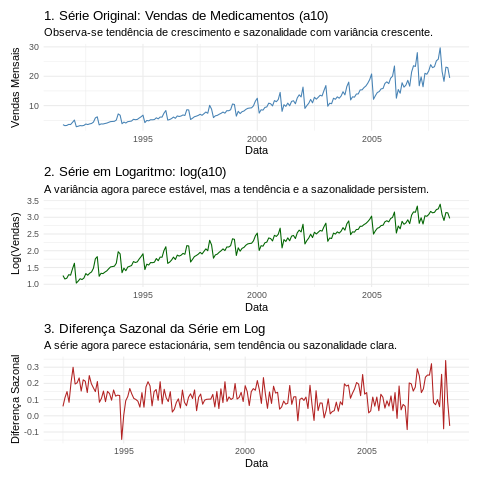

In [17]:
%%R

install.packages("fpp2")     # pacote principal de séries temporais


library(fpp2)

# 'patchwork' para combinar os gráficos facilmente.
if (!require("patchwork")) {
  install.packages("patchwork")
  library(patchwork)
}

# 'timetk' para facilitar a conversão de 'ts' para data.frame (opcional, mas bom)
if (!require("timetk")) {
    install.packages("timetk")
    library(timetk)
}


# --- Passo 2: Preparar os dados ---

# O objeto 'a10' é do tipo 'ts' (time series).
# Vamos convertê-lo para um data.frame para usar com o ggplot2.
dados_a10_df <- tk_tbl(a10, rename_index = "data") %>%
  rename(vendas = value)


# --- Passo 3: Gerar os três gráficos solicitados ---

# Gráfico 1: A série original
p1 <- ggplot(dados_a10_df, aes(x = data, y = vendas)) +
  geom_line(color = "steelblue") +
  labs(title = "1. Série Original: Vendas de Medicamentos (a10)",
       subtitle = "Observa-se tendência de crescimento e sazonalidade com variância crescente.",
       x = "Data",
       y = "Vendas Mensais") +
  theme_minimal()

# Gráfico 2: O log da série
# Primeiro, adicionamos a coluna de log ao nosso data.frame
dados_a10_df$log_vendas <- log(dados_a10_df$vendas)

p2 <- ggplot(dados_a10_df, aes(x = data, y = log_vendas)) +
  geom_line(color = "darkgreen") +
  labs(title = "2. Série em Logaritmo: log(a10)",
       subtitle = "A variância agora parece estável, mas a tendência e a sazonalidade persistem.",
       x = "Data",
       y = "Log(Vendas)") +
  theme_minimal()

# Gráfico 3: A diferença sazonal da série em log
# A função diff() com lag=12 calcula a diferença sazonal para dados mensais.
dados_a10_df$diff_sazonal_log <- c(rep(NA, 12), diff(dados_a10_df$log_vendas, lag = 12))

p3 <- ggplot(na.omit(dados_a10_df), aes(x = data, y = diff_sazonal_log)) +
  geom_line(color = "firebrick") +
  labs(title = "3. Diferença Sazonal da Série em Log",
       subtitle = "A série agora parece estacionária, sem tendência ou sazonalidade clara.",
       x = "Data",
       y = "Diferença Sazonal") +
  theme_minimal()

# --- Passo 4: Combinar e exibir os gráficos ---

# Usando o patchwork para empilhar os três gráficos
(p1 / p2 / p3)

### Ex 9

Pacote fpp3 e seu ecossistema carregados com sucesso.

Gerando o gráfico com o conjunto de dados 'us_change'...


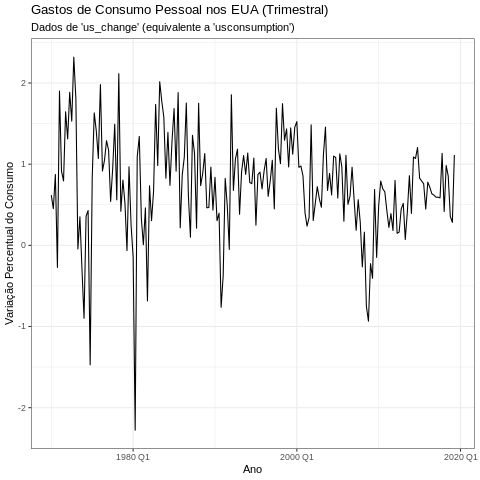

In [29]:
%%R

# --- PASSO 1: INSTALAR OS PACOTES MODERNOS ---
# fpp3 é o sucessor do fpp2. tsibbledata contém os dados.
# quiet = TRUE para não poluir a saída com mensagens de instalação.
if (!require("fpp3", quiet = TRUE)) {
  install.packages("fpp3", quiet = TRUE)
}

# --- PASSO 2: CARREGAR A BIBLIOTECA ---
# Carregar o fpp3 carrega automaticamente ggplot2, dplyr, e o principal: tsibble.
library(fpp3)
cat("Pacote fpp3 e seu ecossistema carregados com sucesso.\n\n")


# --- PASSO 3: ACESSAR E PLOTAR OS DADOS CORRETOS ---
# O dado 'us_change' é o equivalente moderno do 'usconsumption'.
# Ele já é carregado automaticamente com o fpp3.
# A coluna que queremos se chama 'Consumption'.

cat("Gerando o gráfico com o conjunto de dados 'us_change'...\n")

autoplot(us_change, Consumption) +
  labs(title = "Gastos de Consumo Pessoal nos EUA (Trimestral)",
       subtitle = "Dados de 'us_change' (equivalente a 'usconsumption')",
       x = "Ano",
       y = "Variação Percentual do Consumo") +
  theme_bw()

In addition: Warning message:
In ggplot2::geom_segment(lineend = "butt", ...) :
  Ignoring unknown parameters: `lag_max`


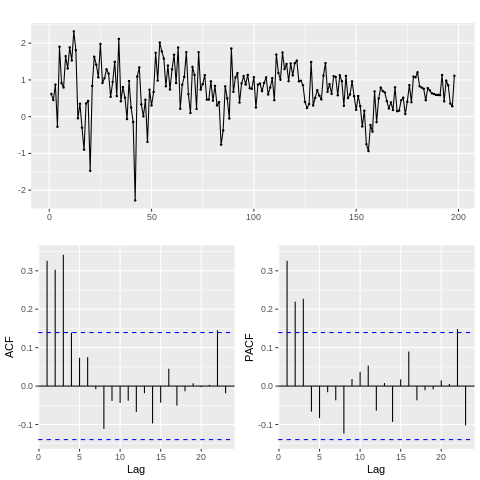

In [38]:
%%R
# Carregamos o pacote fpp3
library(fpp3)

# Selecionamos APENAS a coluna 'Consumption' com o operador $
ggtsdisplay(us_change$Consumption, lag_max = 20)

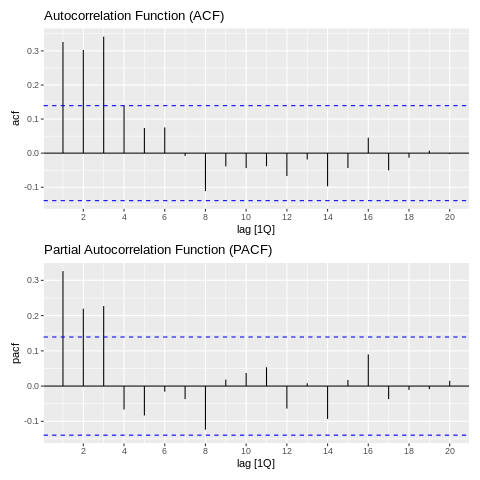

In [37]:
%%R
library(fpp3)

# 1. Calcula a ACF da variável Consumption dentro do tsibble us_change
acf_plot <- us_change %>%
  ACF(Consumption, lag_max = 20) %>%
  autoplot() +
  labs(title = "Autocorrelation Function (ACF)")

# 2. Calcula a PACF da variável Consumption
pacf_plot <- us_change %>%
  PACF(Consumption, lag_max = 20) %>%
  autoplot() +
  labs(title = "Partial Autocorrelation Function (PACF)")

# 3. Usa o patchwork (do fpp3) para mostrar os dois gráficos juntos
acf_plot / pacf_plot

In [36]:
%%R
# Carregamos o pacote fpp3
library(fpp3)

# Exemplo de como seria a sintaxe (NÃO É NECESSÁRIO EXECUTAR PARA ESTE EXERCÍCIO)
us_change_transformado <- us_change %>%
  mutate(
    # Aplicando o logaritmo
    log_consumo = log(Consumption),

    # Aplicando a primeira diferença ao log
    # A função é difference() em vez de diff()
    diff_log_consumo = difference(log_consumo)
  )

# Imprime as primeiras linhas para ver as novas colunas
head(us_change_transformado)

# A tsibble: 6 x 8 [1Q]
  Quarter Consumption Income Production Savings Unemployment log_consumo
    <qtr>       <dbl>  <dbl>      <dbl>   <dbl>        <dbl>       <dbl>
1 1970 Q1       0.619  1.04      -2.45     5.30       0.9        -0.480 
2 1970 Q2       0.452  1.23      -0.551    7.79       0.5        -0.794 
3 1970 Q3       0.873  1.59      -0.359    7.40       0.5        -0.136 
4 1970 Q4      -0.272 -0.240     -2.19     1.17       0.700     NaN     
5 1971 Q1       1.90   1.98       1.91     3.54      -0.1000      0.643 
6 1971 Q2       0.915  1.45       0.902    5.87      -0.1000     -0.0890
# ℹ 1 more variable: diff_log_consumo <dbl>


In addition: Warning message:
There was 1 warning in `mutate()`.
ℹ In argument: `log_consumo = log(Consumption)`.
Caused by warning in `log()`:
! NaNs produced 


### Ex 10

In [40]:
%%R
# Carregamos a biblioteca moderna para séries temporais
library(fpp3)

# Ajustamos o modelo ARIMA automaticamente à série de Consumo
# O fpp3 é inteligente e testa vários modelos para encontrar o melhor
# com base no critério de informação (AICc)
modelo_final <- us_change %>%
  model(ARIMA(Consumption))

# Vamos ver rapidamente qual modelo foi escolhido
report(modelo_final)

Series: Consumption 
Model: ARIMA(1,0,3)(1,0,1)[4] w/ mean 

Coefficients:
          ar1     ma1     ma2     ma3     sar1    sma1  constant
      -0.3413  0.5568  0.3208  0.4084  -0.1459  0.3849    1.1392
s.e.   0.1590  0.1500  0.0922  0.0792   0.2136  0.1806    0.1265

sigma^2 estimated as 0.3324:  log likelihood=-168.58
AIC=353.16   AICc=353.92   BIC=379.46


In addition: Warning message:
`gg_tsresiduals()` was deprecated in feasts 0.4.2.
ℹ Please use `ggtime::gg_tsresiduals()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


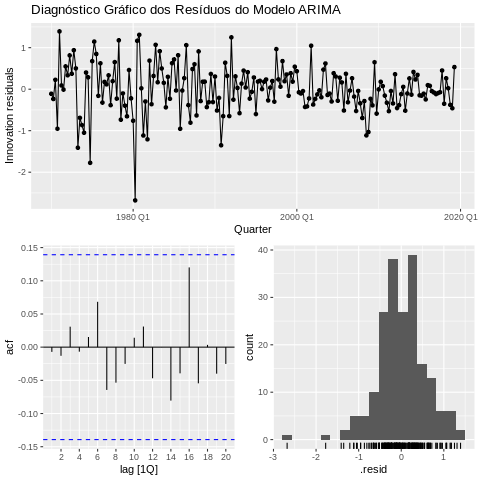

In [41]:
%%R
# Esta função cria os gráficos de resíduos, ACF e histograma de uma vez
gg_tsresiduals(modelo_final, lag_max = 20) +
  labs(title = "Diagnóstico Gráfico dos Resíduos do Modelo ARIMA")

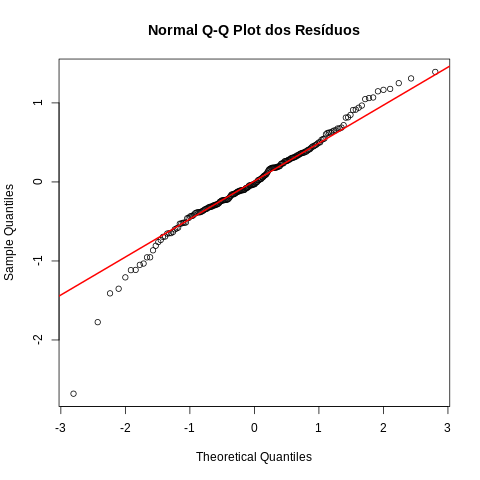

In [42]:
%%R
# Primeiro, extraímos os resíduos do modelo
residuos_df <- residuals(modelo_final)

# Criamos o QQ-Plot
# A função qqnorm plota os quantis, e qqline desenha a linha de referência
qqnorm(residuos_df$.resid, main = "Normal Q-Q Plot dos Resíduos")
qqline(residuos_df$.resid, col = "red", lwd = 2)

In [43]:
%%R
# Extraímos os resíduos
residuos_df <- residuals(modelo_final)

# Realizamos o teste de Ljung-Box nos resíduos
# A função features() é a maneira do fpp3 de calcular estatísticas
residuos_df %>%
  features(.resid, ljung_box, lag = 20)

# A tibble: 1 × 3
  .model             lb_stat lb_pvalue
  <chr>                <dbl>     <dbl>
1 ARIMA(Consumption)    9.58     0.975


In [45]:
%%R
# Instala o pacote se necessário e o carrega
if (!require("tseries")) {
  install.packages("tseries")
}
library(tseries)

# Extrai os resíduos do nosso modelo
residuos_vec <- residuals(modelo_final)$.resid

# Realiza o teste de Jarque-Bera
jarque.bera.test(residuos_vec)


	Jarque Bera Test

data:  residuos_vec
X-squared = 53.87, df = 2, p-value = 2.006e-12

